Largely based on `cifar10_cnn.py` from the Keras examples.

This classifies the images from the CIFAR 10 small image data set using a convolutional neural network (CNN).

In [1]:
%matplotlib inline

from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from IPython.display import display, HTML
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

These are the 10 categories from the CIFAR 10 data set:

In [3]:
category = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

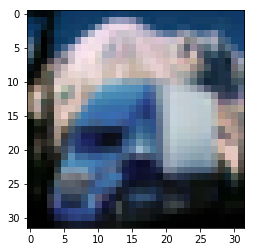

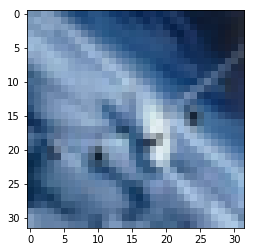

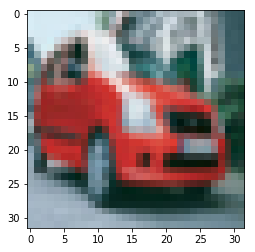

In [4]:
i_s = np.random.randint(0, len(X_train), size=3)

for i in i_s:
    true_label = int(y_train[i])
    plt.imshow(X_train[i]); plt.show()
    display(HTML('{} {}'.format(true_label, category[true_label])))
    

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

In [6]:
print(Y_train[i_s])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [7]:
model_fn = 'cifar10_model.h5'
if os.path.exists(model_fn):
    model = load_model(model_fn)
else:
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(category), activation='softmax'))

    # Fails to converge using RMSprop, see https://github.com/fchollet/keras/issues/4897, so use
    # Adam instead.
    optimizer = 'adam'

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.summary()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    model.fit(X_train, Y_train,
              batch_size=32,
              epochs=50,
              validation_split=0.2,
              callbacks=[early_stopping],
              shuffle=True,
              verbose=2)
    model.save(model_fn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [8]:
metrics = model.evaluate(X_test, Y_test, verbose=False)
for name, metric in zip(model.metrics_names, metrics):
    print('{}: {}'.format(name, metric))

loss: 0.6999098927021027
acc: 0.7744


Here are some example predictions from the test set:

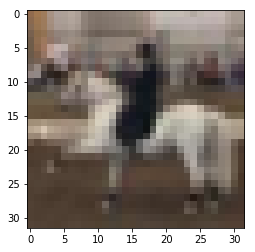

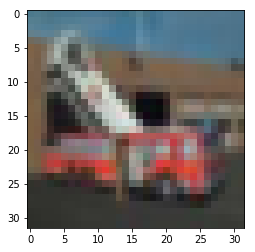

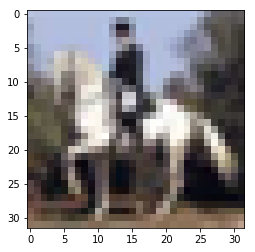

In [9]:
test_i_s = np.random.randint(0, len(X_test), size=3)

for X, pred, true_label in zip(X_test[test_i_s], model.predict_classes(X_test[test_i_s], verbose=False), y_test[test_i_s]):
    true_label = int(true_label)
    plt.imshow(X)
    plt.show()
    
    color = "green" if pred == true_label else "red"
    
    display(HTML(
        '<span style="color: {}">{} {}</span><br/>{} {}'.format(
            color,
            pred, category[pred],
            true_label, category[true_label]
        )
    ))

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(X_test, verbose=False)

C = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[822  11  39  24  18   8   8   7  42  21]
 [ 19 849   4   7   4   6  11   4  23  73]
 [ 62   3 615  68  76  99  46  21   9   1]
 [ 20   4  35 576  48 234  50  25   4   4]
 [ 17   0  41  57 742  45  37  55   5   1]
 [  7   0  24 113  28 780  20  26   1   1]
 [  5   1  28  53  36  32 836   5   3   1]
 [  7   0  19  34  45  82   3 805   1   4]
 [ 65  17   8  17   5   7   3   3 859  16]
 [ 22  41   3  19   6   5   7  15  22 860]]


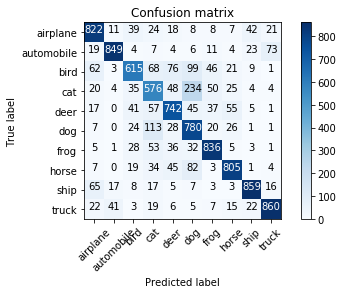

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    From scikit-learn examples.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(C, category)